In [1]:
%run ../nn_option_pricer/_key_imports.py
%run ../nn_option_pricer/nn_archi.py
%run ../nn_option_pricer/bachelier.py

In [4]:
from numpy.linalg import cholesky
from jax import grad
from jax.numpy import vectorize

SEEDS = [42, 2022]
name = ["train", "test"]
for itera in tqdm(range(2)):
    rng = default_rng(SEEDS[itera])

    """
    Define Parameters
    """
    N_ASSETS = 100
    F = N_ASSETS
    N_SAMPLES = 10 ** 4
    T = 1.0
    K = 1.0

    # Covariance matrix
    L = 0.2 * rng.standard_normal((N_ASSETS, F))
    cov = L @ L.T
    assert np.linalg.det(cov) > 0
    L = cholesky(cov)
    w = np.ones((N_ASSETS)) / N_ASSETS

    """
    Define Brownian Motion
    """
    # Simulate St, ST
    Wt = (np.sqrt(30 / 250) * rng.standard_normal((N_SAMPLES, F))) @ L.T
    S0 = 1.0 + Wt
    WT = (np.sqrt(T) * rng.standard_normal((N_SAMPLES, F))) @ L.T

    """
    Calculate Sample Payoffs and Gradients
    """
    XT = (S0 + WT) @ w
    ys = payoff(XT, K)
    payoff_grad = vectorize(grad(payoff))(XT, K)

    grads = np.zeros((N_SAMPLES, N_ASSETS))
    for i in tqdm(range(N_SAMPLES)):
        grads[i, :] = grad(abm_step)(S0[i, :], WT[i, :], w)
    grads = grads * payoff_grad.reshape((-1, 1))

    print(ys.shape, grads.shape, S0.shape)
    assert (ys.shape[0] == grads.shape[0]) & (grads.shape[0] == S0.shape[0])

    X_df = pd.concat(
        [
            pd.DataFrame(S0).add_prefix("asset_"),
            pd.DataFrame(grads).add_prefix("grad_asset"),
        ],
        axis=1,
    )
    X_df["call_payoff"] = ys

    """
    Compute analytic price and all greeks
    """
    X_df["basket"] = S0 @ w
    sigma = np.sqrt(w @ L @ L.T @ w.T)
    print(np.std(X_df["basket"]) / np.sqrt(30 / 250), sigma)

    X_df["call_analytic"] = bachelier_solution(X_df["basket"].values, K, sigma, T)
    X_df["call_analytic_theta"] = vectorize(grad(bachelier_solution, argnums=3))(
        X_df["basket"].values, K, sigma, T
    )
    X_df["call_analytic_delta"] = vectorize(grad(bachelier_solution, argnums=0))(
        X_df["basket"].values, K, sigma, T
    )
    X_df["call_analytic_gamma"] = vectorize(grad(grad(bachelier_solution, argnums=0)))(
        X_df["basket"].values, K, sigma, T
    )

    payoff_MC = np.zeros((N_SAMPLES))
    grad_MC = np.zeros((N_SAMPLES))
    for i in tqdm(range(N_SAMPLES)):
        payoff_MC[i] = np.mean(payoff(abm_step(S0[[i], :], WT, w), 1.0))
        grad_MC[i] = grad(lambda x, WT, w: np.mean(payoff(abm_step(x, WT, w), K)))(
            S0[[i], :], WT, w
        )[:, 0]

    X_df["delta_MC"] = grad_MC
    X_df["call_MC"] = payoff_MC
    X_df.to_csv(f"datasets/bachelier_{name[itera]}.csv", index=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000,) (10000, 100) (10000, 100)
0.20260290079951712 0.20455183160065224


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000,) (10000, 100) (10000, 100)
0.18486574890114713 0.18372483040125445


  0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
!ls

American.ipynb
BSComplete.ipynb
BachelierBasket.ipynb
BasketBachelierDataset.ipynb
BergomiCalls.ipynb
BlackScholesBarrier.ipynb
BlackScholesBarrierDataset.ipynb
BlackScholesCalls.ipynb
BlackScholesDataset.ipynb
BlackScholesDigitals.ipynb
DeepHedgingHeston.ipynb
DeepLearningExam.ipynb
Generator_Test.ipynb
Heston.ipynb
HestonCall.ipynb
HestonDataset.ipynb
HestonDigital.ipynb
JuliaFluxNeuralPDE.jl
NeuralPDE.ipynb
RoughBergomiDataset.ipynb
SABRDataset.ipynb
SABR_Calls.ipynb
SABR_Digital.ipynb
Screen Shot 2022-06-09 at 1.38.06 PM.png
Screen Shot 2022-06-09 at 1.47.30 PM.png
Screen Shot 2022-06-09 at 2.33.38 PM.png
bs_test.csv
bs_train.csv
datasets
model.png


In [ ]:
sns.scatterplot(X_df["basket"], X_df["call_payoff"])
intrinsic_val = np.maximum(X_df["basket"] - 1.0, 0)
print(np.mean(intrinsic_val > 0))

Text(0.5, 1.0, 'PDE error vs Strike')

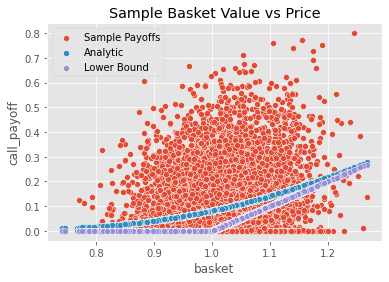

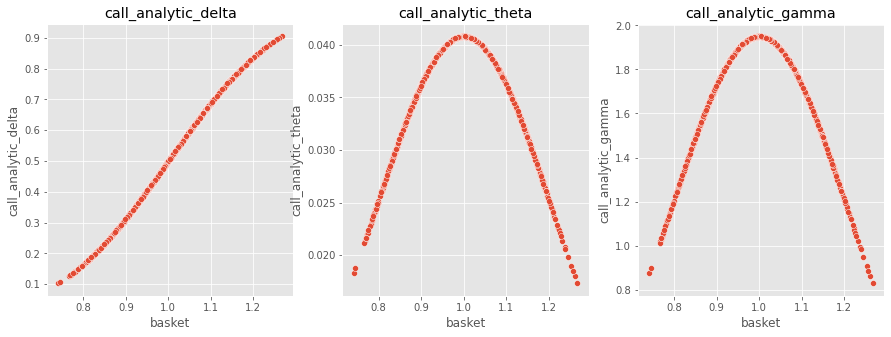

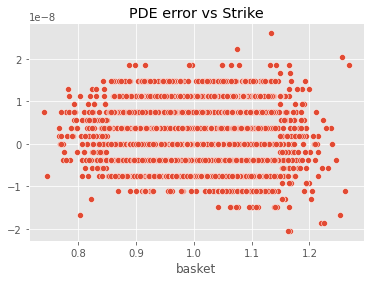

In [5]:
"""
Plot Price v Underlying
"""

fig, ax = plt.subplots()
sns.scatterplot(X_df["basket"], X_df["call_payoff"], ax=ax, label="Sample Payoffs")
sns.scatterplot(X_df["basket"], X_df["call_analytic"], ax=ax, label="Analytic")
sns.scatterplot(
    X_df["basket"], np.maximum(X_df["basket"] - K, 0), label="Lower Bound", ax=ax
)
ax.legend()
ax.set_title("Sample Basket Value vs Price")

"""
Plot Greeks
"""
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, x in enumerate(
    ["call_analytic_delta", "call_analytic_theta", "call_analytic_gamma"]
):
    sns.scatterplot(X_df["basket"], X_df[x], ax=ax[i])
    ax[i].set_title(x)

"""
PDE Err
"""
fig, ax = plt.subplots()
PDE_err = (
    -X_df["call_analytic_theta"] + 0.5 * (sigma ** 2) * X_df["call_analytic_gamma"]
)
sns.scatterplot(X_df["basket"], PDE_err)
ax.set_title("PDE error vs Strike")